In [1]:
%load_ext autoreload
%autoreload 2
import signal
import time
from dsapol import parsec
from dsapol import polbeamform
from dsapol import polcal
from dsapol import dedisp
from dsapol import filt
from dsapol import RMcal
from dsapol import rmtablefuncs
from dsapol import customfilplotfuncs
from dsapol import scatscint
#from dsapol import widget
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import copy
import glob
import csv


import matplotlib.image as mpimg
from numpy.ma import masked_array as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit


from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

import pandas as pd
import mercury as mr
import warnings

from tqdm.notebook import tqdm
from scattering import scat
from scintillation import scint
from PIL import Image


INFO:dsaStore:{"mjd": 60502.003795756, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2024-07-11T00:05:27.953305Z", "msg": "TODO: implement"}
INFO:dsaStore:{"mjd": 60502.00379577953, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2024-07-11T00:05:27.955341Z", "msg": "TODO: implement"}
INFO:dsaStore:{"mjd": 60502.003795817756, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "c-tor", "level": "info", "time": "2024-07-11T00:05:27.958645Z", "msg": "DsaStore created"}


test change


In [2]:
tstartup = Time.now()
app = mr.App(title="PARSEC DSA-110 Burst Analysis Dashboard (beta)", description="With this dashboard, you can conduct DM tuning, scattering analysis, scintillation analysis, RM synthesis, and polarization analysis.")

mercury.App

In [3]:
# Toggle Sliders Button: switches between panels of widgets for different slides
toggle_menu = mr.Select(label='Toggle Widget Panels',
                       value='(4) Scattering Analysis',
                       choices=['(0) Load Data',
                               '(1) Dedispersion Tuning',
                               '(2) Calibration -- Beamform Cal Voltages',
                               '(2) Calibration -- Make Cal Filterbanks',
                               '(2) Calibration -- Choose Cal Observations',
                               r'(2) Calibration -- Make Cal Solutions ($|g_{yy}|$)',
                               r'(2) Calibration -- Make Cal Solutions ($|g_{xx}|/|g_{yy}|$)',
                               r'(2) Calibration -- Make Cal Solutions ($\angle g_{xx} - \angle g_{yy}$)',
                               r'(2) Calibration -- Calibrate',
                               '(3) Filter Weights',
                               '(4) Scattering Analysis',
                               '(5) Scintillation Analysis',
                               '(6) RM Synthesis',
                               '(7) Polarization Analysis',
                               '(8) Archive Data'])

mercury.Select

In [4]:
savesessionbutton = mr.Button(label='Save Session',style='primary')
restoresessionbutton = mr.Button(label='Restore Session',style='primary')

mdown = parsec.restore_screen(savesessionbutton,restoresessionbutton)
mr.Note(mdown)

mercury.Button

mercury.Button

Cached Session: 230307aaao_phineas (2024-06-30T21:50:35.220)

Cached Session: 230307aaao_phineas (2024-06-30T21:50:35.220)

In [5]:
#(0) LOAD DATA
def mywarning(message, category, filename, lineno, file=None, line=None,logfile=''):
    warning_file = open(logfile, "a")
    warning_file.write(warnings.formatwarning(message, category, filename, lineno, line))
    warning_file.close()

hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, polbeamform.logfile)
    #frbfiles = parsec.get_frbfiles()
    frbfiles_menu = mr.Select(label="FRB (candname_nickname):", 
                                value=parsec.wdict['frbfiles_menu'],
                                choices=parsec.frbfiles,
                                hidden=hidden)#frbfiles[0], choices=frbfiles,hidden=hidden)
    #load polcal data
    polcalloadbutton = mr.Checkbox(value=parsec.wdict['polcalloadbutton'], 
                                   label="Load Pre-Calibrated Data",hidden=hidden)

    base_n_t_slider = mr.Slider( #time downsampling factor
        value=parsec.wdict['base_n_t_slider'],
        min=1, 
        max=128, 
        step=1, 
        label=r'base $n_t$'
    ,hidden=hidden)
    base_logn_f_slider = mr.Slider( #freq downsampling factor
        value=parsec.wdict['base_logn_f_slider'],
        min=0, 
        max=10, 
        step=1, 
        label=r'base ${\rm log_{2}}({\rm n_f})$'
    ,hidden=hidden)
    logibox_slider_init = mr.Slider(
        value=parsec.wdict['logibox_slider_init'],
        min=0, 
        max=6, 
        step=1, 
        label=r'${\rm log_{2}}({\rm ibox})$'
    ,hidden=hidden)

    buff_L_slider_init = mr.Slider(
        value=parsec.wdict['buff_L_slider_init'],
        min=1, 
        max=128, 
        step=1, 
        label=r'${\rm buff}_{L}$'
    ,hidden=hidden)
    buff_R_slider_init = mr.Slider(
        value=parsec.wdict['buff_R_slider_init'],
        min=1, 
        max=128, 
        step=1, 
        label=r'${\rm buff}_{R}$'
    ,hidden=hidden)



    updatebutton = mr.Button(label='Update FRB Params',style='primary',hidden=hidden)
    filbutton = mr.Button(label='Make Filterbanks',style='primary',hidden=hidden)
    loadbutton = mr.Button(label='Load FRB Data',style='primary',hidden=hidden)
    refreshlogbutton = mr.Button(label='Refresh Log',style='primary',hidden=hidden)


    #showlog = mr.Checkbox(value=parsec.wdict['showlog'], label="Show Beamformer Log",hidden=hidden)



    #get parameters for default frb
    """ids = frbfiles_menu.value[:frbfiles_menu.value.index('_')]
    RA = parsec.FRB_RA[parsec.FRB_IDS.index(ids)]
    DEC = parsec.FRB_DEC[parsec.FRB_IDS.index(ids)]
    ibeam = int(parsec.FRB_BEAM[parsec.FRB_IDS.index(ids)])
    mjd = parsec.FRB_mjd[parsec.FRB_IDS.index(ids)]
    mjd_display = mr.NumberBox(data=mjd,title=r'MJD')
    DMinit = parsec.FRB_DM[parsec.FRB_IDS.index(ids)]
    """

    RA_display = mr.NumberBox(data=parsec.wdict['RA_display'], title=r'RA ($^{\circ}$)')
    DEC_display = mr.NumberBox(data=parsec.wdict['DEC_display'], title=r'DEC ($^{\circ}$)')
    ibeam_display = mr.NumberBox(data=parsec.wdict['ibeam_display'], title=r'ibeam')
    mjd_display = mr.NumberBox(data=parsec.wdict['mjd_display'],title=r'MJD')
    DM_init_display = mr.NumberBox(data=parsec.wdict['DM_init_display'], 
                                title=r'DM (pc/cm$^{{3}}$)'
                               )
    z_display = mr.NumberBox(data=parsec.wdict['z_display'], 
                                title=r'Redshift z'
                               )

    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, dedisp.logfile)
    
    #widgets for DM tuning dashboard
    n_t_slider = mr.Slider( #time downsampling factor
        value=parsec.wdict['n_t_slider'],
        min=1, 
        max=128, 
        step=1, 
        label='$n_t$'
    ,hidden=hidden)
    logn_f_slider = mr.Slider( #freq downsampling factor
        value=parsec.wdict['logn_f_slider'],
        min=0, 
        max=10, 
        step=1, 
        label='${\\rm log_{2}}(n_f)$'
    ,hidden=hidden)
    logwindow_slider_init = mr.Slider(
        value=parsec.wdict['logwindow_slider_init'],
        min=5, 
        max=9, 
        step=1, 
        label=r'base ${\rm log_{2}}({\rm window})$'
    ,hidden=hidden)
    dmstep = dedisp.get_min_DM_step(n_t_slider.value)#np.around((32.7e-3)*n_t_slider.value/(4.15)/((1/1.307**2) - (1/1.493**2)),2) #pc/cc
    ddm_num = mr.Numeric(value=parsec.wdict['ddm_num'], #DM offset
                         step=dmstep,
                         min=-100,max=100,
                         label='$\Delta {\\rm DM}$'
                        ,hidden=hidden)

    DMdonebutton = mr.Button(label='Confirm DM',
                             style='primary',
                            hidden=hidden)
    saveplotbutton = mr.Button(label='Save Plot',
                             style='primary',
                            hidden=hidden)

#(2) CALIBRATION

hidden = '(2)' not in toggle_menu.value 
if not hidden:
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, polcal.logfile)
    


    hidden = toggle_menu.value != '(2) Calibration -- Beamform Cal Voltages'

    """polcaldates = []
    for k in parsec.polcal_dict.keys():
        if 'polcal' not in str(k):
            polcaldates.append(str(k))"""
    polcaldate_create_menu = mr.Select(label="Observation Date for New Polarization Calibration Solution ('YYYY-MM-DD'):", 
                                value=parsec.wdict['polcaldate_create_menu'], 
                                choices=[""] + list(parsec.polcaldates)
                               ,hidden=hidden)
    polcopybutton = mr.Button(label='Copy T3 Voltages and Beamformer Weights',
                             style='primary',hidden=hidden)


    #if we want to create new cal solutions from voltage files that are ALREADY COPIED TO H23 choose from here
    #polcalfiles_bf = polcal.get_avail_caldates()
    polcaldate_bf_menu = mr.Select(label="Available Polarization Calibration Dates ('YYYY-MM-DD'):", 
                                value=parsec.wdict['polcaldate_bf_menu'], 
                                choices=[""] + list(parsec.polcalfiles_bf)
                               ,hidden=hidden)


    bfcal_button = mr.Button(label='Run Cal Beamformer',style='primary',hidden=hidden)

    hidden = (toggle_menu.value != '(2) Calibration -- Make Cal Filterbanks') and (toggle_menu.value != '(2) Calibration -- Choose Cal Observations')

    polcaldate_findbeams_menu = mr.Select(label="Available Dates With Voltages or Filterbanks on h23 ('YYYY-MM-DD'):", 
                                    value=parsec.wdict['polcaldate_findbeams_menu'],#polcalfiles_findbeams[0], 
                                    choices=list(parsec.polcalfiles_findbeams)
                                   ,hidden=hidden)

    hidden = toggle_menu.value != '(2) Calibration -- Make Cal Filterbanks'

    findbeams_button = mr.Button(label='Find Beam Numbers',style='primary',hidden=hidden)
    filcalbutton = mr.Button(label='Make Calibrator Filterbanks',style='primary',hidden=hidden)


    refreshlogcalbutton = mr.Button(label='Refresh Log',style='primary',hidden=hidden)

    hidden = toggle_menu.value != '(2) Calibration -- Choose Cal Observations'
    
    #if we want to make solution from filterbanks
    obs_files,obs_ids = polcal.get_calfil_files('3C48',polcaldate_findbeams_menu.value,'3C48*0')
    #initval = ''
    """if 'cal_name_3C48_center' in parsec.polcal_dict.keys():
        initval = parsec.polcal_dict['cal_name_3C48_center']
    """
    obsid3C48_menu = mr.Select(label="3C48 Cal Observation ID:", 
                                value=parsec.wdict['obsid3C48_menu'], 
                                choices=[""] + list(obs_ids)
                               ,hidden=hidden)
    obs_files,obs_ids = polcal.get_calfil_files('3C286',polcaldate_findbeams_menu.value,'3C286*0')
    #initval = ''
    """if 'cal_name_3C286_center' in parsec.polcal_dict.keys():
        initval = parsec.polcal_dict['cal_name_3C286_center']
    """
    obsid3C286_menu = mr.Select(label="3C286 Cal Observation ID:", 
                                value=parsec.wdict['obsid3C286_menu'], 
                                choices=[""] + list(obs_ids)
                               ,hidden=hidden)
    ParA_display = mr.NumberBox(data=parsec.wdict['ParA_display'], title=r'Parallactic Angle ($^{\circ}$)') 

    saveplotbutton = mr.Button(label='Save Plot',
                             style='primary',
                            hidden=hidden)
    
    hidden = toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($|g_{yy}|$)'

    peakheight_slider = mr.Slider( 
        value=parsec.wdict['peakheight_slider'],
        min=1, 
        max=10, 
        step=1, 
        label=r'Peak Height'
    ,hidden=hidden)
    peakwidth_slider = mr.Slider( 
        value=parsec.wdict['peakwidth_slider'],
        min=1, 
        max=20, 
        step=1, 
        label=r'Peak Width'
    ,hidden=hidden)
    sfflag =  mr.Checkbox(value=parsec.wdict['sfflag'], label="Savgol Filter",hidden=hidden)
    sf_window_weight_cals = mr.Slider( 
        value=parsec.wdict['sf_window_weight_cals'],
        min=3, 
        max=510, 
        step=2, 
        label=r'$sf_{ww}$'
    ,hidden=hidden)
    sf_order_cals = mr.Slider( 
        value=parsec.wdict['sf_order_cals'],
        min=1, 
        max=10, 
        step=1, 
        label=r'$sf_{o}$'
    ,hidden=hidden)
    polyfitflag =  mr.Checkbox(value=parsec.wdict['polyfitflag'], label="Fit with Polynomial",hidden=hidden)
    polyfitorder_slider = mr.Slider( 
        value=parsec.wdict['polyfitorder_slider'],
        min=1, 
        max=9, 
        step=1, 
        label=r'Polynomial Fit Degree'
    ,hidden=hidden)
    edgefreq_slider = mr.Slider( 
        value=parsec.wdict['edgefreq_slider'],
        min=1311.25000003072, 
        max=1498.75, 
        step=30.4e-3, 
        label=r'Edge Frequency (MHz) Cutoff (for Fitting Piecewise Solution)'
    ,hidden=hidden)
    breakfreq_slider = mr.Slider( 
        value=parsec.wdict['breakfreq_slider'],
        min=1311.25000003072, 
        max=1498.75, 
        step=30.4e-3, 
        label=r'Break Frequency (MHz) Cutoff (for Stitching Piecewise Solution)'
    ,hidden=hidden)



    hidden = toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($|g_{xx}|/|g_{yy}|$)'
    ratio_peakheight_slider = mr.Slider( 
        value=parsec.wdict['ratio_peakheight_slider'],
        min=1, 
        max=10, 
        step=1, 
        label=r'Peak Height'
    ,hidden=hidden)
    ratio_peakwidth_slider = mr.Slider( 
        value=parsec.wdict['ratio_peakwidth_slider'],
        min=1, 
        max=20, 
        step=1, 
        label=r'Peak Width'
    ,hidden=hidden)
    ratio_sfflag =  mr.Checkbox(value=parsec.wdict['ratio_sfflag'], label="Savgol Filter",hidden=hidden)
    ratio_sf_window_weight_cals = mr.Slider( 
        value=parsec.wdict['ratio_sf_window_weight_cals'],
        min=3, 
        max=510, 
        step=2, 
        label=r'$sf_{ww}$'
    ,hidden=hidden)
    ratio_sf_order_cals = mr.Slider( 
        value=parsec.wdict['ratio_sf_order_cals'],
        min=1, 
        max=10, 
        step=1, 
        label=r'$sf_{o}$'
    ,hidden=hidden)
    ratio_polyfitflag =  mr.Checkbox(value=parsec.wdict['ratio_polyfitflag'], label="Fit with Polynomial",hidden=hidden)
    ratio_polyfitorder_slider = mr.Slider( 
        value=parsec.wdict['ratio_polyfitorder_slider'],
        min=1, 
        max=9, 
        step=1, 
        label=r'Polynomial Fit Degree'
    ,hidden=hidden)
    ratio_edgefreq_slider = mr.Slider( 
        value=parsec.wdict['ratio_edgefreq_slider'],
        min=1311.25000003072, 
        max=1498.75, 
        step=30.4e-3, 
        label=r'Edge Frequency (MHz) Cutoff (for Fitting Piecewise Solution)'
    ,hidden=hidden)
    ratio_breakfreq_slider = mr.Slider( 
        value=parsec.wdict['ratio_breakfreq_slider'],
        min=1311.25000003072, 
        max=1498.75, 
        step=30.4e-3, 
        label=r'Break Frequency (MHz) Cutoff (for Stitching Piecewise Solution)'
    ,hidden=hidden)


    hidden = toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($\angle g_{xx} - \angle g_{yy}$)'
    phase_peakheight_slider = mr.Slider( 
        value=parsec.wdict['phase_peakheight_slider'],
        min=1, 
        max=10, 
        step=1, 
        label=r'Peak Height'
    ,hidden=hidden)
    phase_peakwidth_slider = mr.Slider( 
        value=parsec.wdict['phase_peakwidth_slider'],
        min=1, 
        max=20, 
        step=1, 
        label=r'Peak Width'
    ,hidden=hidden)
    phase_sfflag =  mr.Checkbox(value=parsec.wdict['phase_sfflag'], label="Savgol Filter",hidden=hidden)
    phase_sf_window_weight_cals = mr.Slider( 
        value=parsec.wdict['phase_sf_window_weight_cals'],
        min=3, 
        max=510, 
        step=2, 
        label=r'$sf_{ww}$'
    ,hidden=hidden)
    phase_sf_order_cals = mr.Slider( 
        value=parsec.wdict['phase_sf_order_cals'],
        min=1, 
        max=10, 
        step=1, 
        label=r'$sf_{o}$'
    ,hidden=hidden)
    phase_polyfitflag =  mr.Checkbox(value=parsec.wdict['phase_polyfitflag'], label="Fit with Polynomial",hidden=hidden)
    phase_polyfitorder_slider = mr.Slider( 
        value=parsec.wdict['phase_polyfitorder_slider'],
        min=1, 
        max=9, 
        step=1, 
        label=r'Polynomial Fit Degree'
    ,hidden=hidden)

    savecalsolnbutton = mr.Button(label='Save Cal Solution',
                             style='primary',hidden=hidden)

    hidden = toggle_menu.value != r'(2) Calibration -- Calibrate'
    #if pol cal solution already exists
    #polcalfiles = glob.glob(parsec.default_path + 'POLCAL_PARAMETERS_*csv')
    #polcalfiles = [polcalfiles[i][polcalfiles[i].index('POLCAL'):] for i in range(len(polcalfiles))]
    polcaldate_menu = mr.Select(label="Polarization Calibration File ('YY-MM-DD'):", 
                                value=parsec.wdict['polcaldate_menu'], 
                                choices=[""] + parsec.polcalfiles
                               ,hidden=hidden)

    polcalbutton = mr.Button(label='Calibrate',
                             style='primary',hidden=hidden)


    #showlogcal = mr.Checkbox(value=parsec.wdict['showlogcal'], label="Show Pol Cal Log",hidden=hidden)

    hidden = ((toggle_menu.value != r'(2) Calibration -- Calibrate') and
              (toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($|g_{yy}|$)') and 
              (toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($|g_{xx}|/|g_{yy}|$)') and
              (toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($\angle g_{xx} - \angle g_{yy}$)'))
    saveplotbutton = mr.Button(label='Save Plot',
                             style='primary',
                            hidden=hidden)

#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, filt.logfile)
    
    
    MAXCOMPS = 5
    ncomps_num = mr.Numeric(value=parsec.wdict['ncomps_num'], 
                         step=1,
                         min=1,max=MAXCOMPS,
                         label='Number of Components'
                        ,hidden=hidden)
    comprange_slider = mr.Range(value=parsec.wdict['comprange_slider'],  #ms
                            min=0, 
                            max=20, 
                            label="Lower and Upper Limit of Component (ms from window start)", 
                            step=32.7e-3
                    ,hidden=hidden)
    """n_t_slider_filt = mr.Slider( #time downsampling factor
        value=parsec.wdict['n_t_slider_filt'],
        min=1, 
        max=128, 
        step=1, 
        label='$n_t$'
    ,hidden=hidden)
    logn_f_slider_filt = mr.Slider( #freq downsampling factor
        value=parsec.wdict['logn_f_slider_filt'],
        min=0, 
        max=10, 
        step=1, 
        label='${\\rm log_{2}}(n_f)$'
    ,hidden=hidden)"""

    multipeaks = mr.Checkbox(value=parsec.wdict['multipeaks'], label="Multiple Peaks",hidden=hidden)
    multipeaks_height_slider = mr.Slider(
        value=parsec.wdict['multipeaks_height_slider'],
        min=0, 
        max=1, 
        step=0.01, 
        label="Minimum Peak Height"
    ,hidden=hidden)

    avger_w_slider = mr.Slider(
        value=parsec.wdict['avger_w_slider'],
        min=1, 
        max=32, 
        step=1, 
        label=r'$n_{tw}$'
    ,hidden=hidden)
    sf_window_weights_slider = mr.Slider(
        value=parsec.wdict['sf_window_weights_slider'],
        min=3, 
        max=33, 
        step=2, 
        label=r'$sf_{ww}$'
    ,hidden=hidden)
    logibox_slider = mr.Slider(
        value=parsec.wdict['logibox_slider'],
        min=0, 
        max=6, 
        step=1, 
        label=r'${\rm log_{2}}({\rm ibox})$'
    ,hidden=hidden)
    logwindow_slider = mr.Slider(
        value=parsec.wdict['logwindow_slider'],
        min=5, 
        max=9, 
        step=1, 
        label=r'base ${\rm log_{2}}({\rm window})$'
    ,hidden=hidden)

    buff_L_slider = mr.Slider(
        value=parsec.wdict['buff_L_slider'],
        min=1, 
        max=128, 
        step=1, 
        label=r'${\rm buff}_{L}$'
    ,hidden=hidden)
    buff_R_slider = mr.Slider(
        value=parsec.wdict['buff_R_slider'],
        min=1, 
        max=128, 
        step=1, 
        label=r'${\rm buff}_{R}$'
    ,hidden=hidden)

    nextcompbutton = mr.Button(label='Next Component',
                             style='primary',hidden=hidden)

    donecompbutton = mr.Button(label='Done',
                             style='primary',hidden=hidden)

    fluxestbutton = mr.Button(label='Estimate Absolute Flux in Jy',
                             style='primary',hidden=hidden)

    Iflux_display = mr.NumberBox(data=parsec.wdict['Iflux_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'I (Jy)'
                                   )
    Qflux_display = mr.NumberBox(data=parsec.wdict['Qflux_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'Q (Jy)'
                                   )
    Uflux_display = mr.NumberBox(data=parsec.wdict['Uflux_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'U (Jy)'
                                   )
    Vflux_display = mr.NumberBox(data=parsec.wdict['Vflux_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'V (Jy)'
                                   )
    
    
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, scatscint.logfile)
    
    scattermenu = mr.MultiSelect(label="Components", 
                              value=parsec.wdict['scattermenu'], 
                              choices=parsec.wdict['scattermenu_choices'],
                                hidden=hidden)

    scatfitmenu = mr.Select(label="Fitting Method",
                            value=parsec.wdict['scatfitmenu'],
                            choices=parsec.wdict['scatfitmenu_choices'],
                            hidden=hidden)
    
    refresh_button = mr.Button(label=r'Refresh from Background Processes',style='primary',hidden=hidden)
    
    scatterbackground = mr.Checkbox(value=parsec.wdict['scatterbackground'],label="Run in Background",hidden=hidden)

    scatterweights = mr.Checkbox(value=parsec.wdict['scatterweights'],label="Weighted Fit",hidden=hidden)
    scatterresume = mr.Checkbox(value=parsec.wdict['scatterresume'],label="Resume Last Run",hidden=hidden)
    
    scatter_init = mr.Button(label=r'Reset Sliders to Initial Values',style='primary',hidden=hidden)
    if scatter_init.clicked:
        for i in range(parsec.state_dict['n_comps']):
            parsec.scatter_reset_initvals(i)
            
    scatter_nlive = mr.Numeric(value=parsec.wdict['scatter_nlive'], 
                         step=1,
                         min=1,max=1000000,
                         label='nlive'
                        ,hidden=hidden)
    scatter_sliderrange = mr.Numeric(value=parsec.wdict['scatter_sliderrange'], 
                         step=0.1,
                         min=0.1,max=1,
                         label='Max Slider Range'
                        ,hidden=hidden)
    #create sliders for each component
    x0_guess_comps = []
    amp_guess_comps = []
    sigma_guess_comps = []
    tau_guess_comps = []
    
    x0_range_sliders = []
    amp_range_sliders = []
    sigma_range_sliders = []
    tau_range_sliders = []
    
    hiddens = []

    #comp 0
    hiddens.append(hidden | ('Component 0' not in scattermenu.value))
    #if not hiddens[0]:
    #    note_0 = mr.Note('Component 0')         
    x0_guess_0 = mr.Numeric(value=parsec.wdict['x0_guess_0'], 
                 step=32.7e-3,
                 min=0,max=0.7e3,
                 label=r'(Comp 0) $x_0$ Initial Guess (ms)'
                ,hidden=hiddens[0])
    x0_range_0 = mr.Range(value=parsec.wdict['x0_range_0'],  #ms
                            min=x0_guess_0.value*(1 - scatter_sliderrange.value), 
                            max=x0_guess_0.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 0) $x_0$ Search Range (ms)', 
                            step=32.7e-3
                    ,hidden=hiddens[0])
    if not hiddens[0]:
        x0_guess_comps.append(x0_guess_0)
        x0_range_sliders.append(x0_range_0)
        
    amp_guess_0 = mr.Numeric(value=parsec.wdict['amp_guess_0'], 
                         step=1e-3,
                         min=0,max=500,
                         label=r'(Comp 0) Amplitude Initial Guess'
                        ,hidden=hiddens[0])
    amp_range_0 = mr.Range(value=parsec.wdict['amp_range_0'],  #ms
                            min=amp_guess_0.value*(1 - scatter_sliderrange.value), 
                            max=amp_guess_0.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 0) Amplitude Search Range', 
                            step=1e-3
                    ,hidden=hiddens[0])
    if not hiddens[0]:
        amp_guess_comps.append(amp_guess_0)
        amp_range_sliders.append(amp_range_0)

    sigma_guess_0 = mr.Numeric(value=parsec.wdict['sigma_guess_0'], 
                         step=1e-3,
                         min=0,max=0.2e3,
                         label=r'(Comp 0) $\sigma$ Initial Guess (ms)'
                        ,hidden=hiddens[0])
    sigma_range_0 = mr.Range(value=parsec.wdict['sigma_range_0'],  #ms
                            min=sigma_guess_0.value*(1 - scatter_sliderrange.value), 
                            max=sigma_guess_0.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 0) $\sigma$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[0])
    if not hiddens[0]:
        sigma_guess_comps.append(sigma_guess_0)
        sigma_range_sliders.append(sigma_range_0)

    tau_guess_0 = mr.Numeric(value=parsec.wdict['tau_guess_0'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 0) $\tau$ Search Range (ms)'
                        ,hidden=hiddens[0])
    tau_range_0 = mr.Range(value=parsec.wdict['tau_range_0'],  #ms
                            min=tau_guess_0.value*(1 - scatter_sliderrange.value), 
                            max=tau_guess_0.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 0) $\tau$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[0])
    if not hiddens[0]:
        tau_guess_comps.append(tau_guess_0)
        tau_range_sliders.append(tau_range_0)

    #comp 1
    hiddens.append(hidden | ('Component 1' not in scattermenu.value))
    #if not hiddens[1]:
    #    note_1 = mr.Note('Component 1')         
    x0_guess_1 = mr.Numeric(value=parsec.wdict['x0_guess_1'], 
                 step=32.7e-3,
                 min=0,max=0.7e3,
                 label=r'(Comp 1) $x_0$ Initial Guess (ms)'
                ,hidden=hiddens[1])
    x0_range_1 = mr.Range(value=parsec.wdict['x0_range_1'],  #ms
                            min=x0_guess_1.value*(1 - scatter_sliderrange.value), 
                            max=x0_guess_1.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 1) $x_0$ Search Range (ms)', 
                            step=32.7e-3
                    ,hidden=hiddens[1])
    if not hiddens[1]:
        x0_guess_comps.append(x0_guess_1)
        x0_range_sliders.append(x0_range_1)

    amp_guess_1 = mr.Numeric(value=parsec.wdict['amp_guess_1'], 
                         step=1e-3,
                         min=0,max=500,
                         label=r'(Comp 1) Amplitude Initial Guess'
                        ,hidden=hiddens[1])
    amp_range_1 = mr.Range(value=parsec.wdict['amp_range_1'],  #ms
                            min=amp_guess_1.value*(1 - scatter_sliderrange.value), 
                            max=amp_guess_1.value*(1 + scatter_sliderrange.value), 
                            label="(Comp 1) Amplitude Search Range", 
                            step=1e-3
                    ,hidden=hiddens[1])
    if not hiddens[1]:
        amp_guess_comps.append(amp_guess_1)
        amp_range_sliders.append(amp_range_1)

    sigma_guess_1 = mr.Numeric(value=parsec.wdict['sigma_guess_1'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 1) $\sigma$ Initial Guess (ms)'
                        ,hidden=hiddens[1])
    sigma_range_1 = mr.Range(value=parsec.wdict['sigma_range_1'],  #ms
                            min=sigma_guess_1.value*(1 - scatter_sliderrange.value), 
                            max=sigma_guess_1.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 1) $\sigma$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[1])
    if not hiddens[1]:
        sigma_guess_comps.append(sigma_guess_1)
        sigma_range_sliders.append(sigma_range_1)

    tau_guess_1 = mr.Numeric(value=parsec.wdict['tau_guess_1'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 1) $\tau$ Initial Guess'
                        ,hidden=hiddens[1])
    tau_range_1 = mr.Range(value=parsec.wdict['tau_range_1'],  #ms
                            min=tau_guess_1.value*(1 - scatter_sliderrange.value), 
                            max=tau_guess_1.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 1) $\tau$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[1])
    if not hiddens[1]:
        tau_guess_comps.append(tau_guess_1)
        tau_range_sliders.append(tau_range_1)

    #comp 2
    hiddens.append(hidden | ('Component 2' not in scattermenu.value))
    #if not hiddens[2]:
    #    note_2 = mr.Note('Component 2')         
    x0_guess_2 = mr.Numeric(value=parsec.wdict['x0_guess_2'], 
                 step=32.7e-3,
                 min=0,max=0.7e3,
                 label=r'(Comp 2) $x_0$ Initial Guess (ms)'
                ,hidden=hiddens[2])
    x0_range_2 = mr.Range(value=parsec.wdict['x0_range_2'],  #ms
                            min=x0_guess_2.value*(1 - scatter_sliderrange.value), 
                            max=x0_guess_2.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 2) $x_0$ Search Range (ms)', 
                            step=32.7e-3
                    ,hidden=hiddens[2])
    if not hiddens[2]:
        x0_guess_comps.append(x0_guess_2)
        x0_range_sliders.append(x0_range_2)

    amp_guess_2 = mr.Numeric(value=parsec.wdict['amp_guess_2'], 
                         step=1e-3,
                         min=0,max=500,
                         label=r'(Comp 2) Amplitude Initial Guess'
                        ,hidden=hiddens[2])
    amp_range_2 = mr.Range(value=parsec.wdict['amp_range_2'],  #ms
                            min=amp_guess_2.value*(1 - scatter_sliderrange.value), 
                            max=amp_guess_2.value*(1 + scatter_sliderrange.value), 
                            label="(Comp 2) Amplitude Search Range", 
                            step=1e-3
                    ,hidden=hiddens[2])
    if not hiddens[2]:
        amp_guess_comps.append(amp_guess_2)
        amp_range_sliders.append(amp_range_2)

    sigma_guess_2 = mr.Numeric(value=parsec.wdict['sigma_guess_2'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 2) $\sigma$ Initial Guess (ms)'
                        ,hidden=hiddens[2])
    sigma_range_2 = mr.Range(value=parsec.wdict['sigma_range_2'],  #ms
                            min=sigma_guess_2.value*(1 - scatter_sliderrange.value), 
                            max=sigma_guess_2.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 2) $\sigma$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[2])
    if not hiddens[2]:
        sigma_guess_comps.append(sigma_guess_2)
        sigma_range_sliders.append(sigma_range_2)

    tau_guess_2 = mr.Numeric(value=parsec.wdict['tau_guess_2'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 2) $\tau$ Initial Guess'
                        ,hidden=hiddens[2])
    tau_range_2 = mr.Range(value=parsec.wdict['tau_range_2'],  #ms
                            min=tau_guess_2.value*(1 - scatter_sliderrange.value), 
                            max=tau_guess_2.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 2) $\tau$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[2])
    if not hiddens[2]:
        tau_guess_comps.append(tau_guess_2)
        tau_range_sliders.append(tau_range_2)

    #comp 3
    hiddens.append(hidden | ('Component 3' not in scattermenu.value))
    #if not hiddens[3]:
    #    note_3 = mr.Note('Component 3')         
    x0_guess_3 = mr.Numeric(value=parsec.wdict['x0_guess_3'], 
                 step=32.7e-3,
                 min=0,max=0.7e3,
                 label=r'(Comp 3) $x_0$ Initial Guess (ms)'
                ,hidden=hiddens[3])
    x0_range_3 = mr.Range(value=parsec.wdict['x0_range_3'],  #ms
                            min=x0_guess_3.value*(1 - scatter_sliderrange.value), 
                            max=x0_guess_3.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 3) $x_0$ Search Range (ms)', 
                            step=32.7e-3
                    ,hidden=hiddens[3])
    if not hiddens[3]:
        x0_guess_comps.append(x0_guess_3)
        x0_range_sliders.append(x0_range_3)

    amp_guess_3 = mr.Numeric(value=parsec.wdict['amp_guess_3'], 
                         step=1e-3,
                         min=0,max=500,
                         label=r'(Comp 3) Amplitude Initial Guess'
                        ,hidden=hiddens[3])
    amp_range_3 = mr.Range(value=parsec.wdict['amp_range_3'],  #ms
                            min=amp_guess_3.value*(1 - scatter_sliderrange.value), 
                            max=amp_guess_3.value*(1 + scatter_sliderrange.value), 
                            label="(Comp 3) Amplitude Search Range", 
                            step=1e-3
                    ,hidden=hiddens[3])
    if not hiddens[3]:
        amp_guess_comps.append(amp_guess_3)
        amp_range_sliders.append(amp_range_3)

    sigma_guess_3 = mr.Numeric(value=parsec.wdict['sigma_guess_3'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 3) $\sigma$ Initial Guess (ms)'
                        ,hidden=hiddens[3])
    sigma_range_3 = mr.Range(value=parsec.wdict['sigma_range_3'],  #ms
                            min=sigma_guess_3.value*(1 - scatter_sliderrange.value), 
                            max=sigma_guess_3.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 3) $\sigma$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[3])
    if not hiddens[3]:
        sigma_guess_comps.append(sigma_guess_3)
        sigma_range_sliders.append(sigma_range_3)

    tau_guess_3 = mr.Numeric(value=parsec.wdict['tau_guess_3'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 3) $\tau$ Initial Guess'
                        ,hidden=hiddens[3])
    tau_range_3 = mr.Range(value=parsec.wdict['tau_range_3'],  #ms
                            min=tau_guess_3.value*(1 - scatter_sliderrange.value), 
                            max=tau_guess_3.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 3) $\tau$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[3])
    if not hiddens[3]:
        tau_guess_comps.append(tau_guess_3)
        tau_range_sliders.append(tau_range_3)

    #comp 4
    hiddens.append(hidden | ('Component 4' not in scattermenu.value))
    #if not hiddens[4]:
    #    note_4 = mr.Note('Component 4')         
    x0_guess_4 = mr.Numeric(value=parsec.wdict['x0_guess_4'], 
                 step=32.7e-3,
                 min=0,max=0.7e3,
                 label=r'(Comp 4) $x_0$ Initial Guess (ms)'
                ,hidden=hiddens[4])
    x0_range_4 = mr.Range(value=parsec.wdict['x0_range_4'],  #ms
                            min=x0_guess_4.value*(1 - scatter_sliderrange.value), 
                            max=x0_guess_4.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 4) $x_0$ Search Range (ms)', 
                            step=32.7e-3
                    ,hidden=hiddens[4])
    if not hiddens[4]:
        x0_guess_comps.append(x0_guess_4)
        x0_range_sliders.append(x0_range_4)

    amp_guess_4 = mr.Numeric(value=parsec.wdict['amp_guess_4'], 
                         step=1e-3,
                         min=0,max=500,
                         label=r'(Comp 4) Amplitude Initial Guess'
                        ,hidden=hiddens[4])
    amp_range_4 = mr.Range(value=parsec.wdict['amp_range_4'],  #ms
                            min=amp_guess_4.value*(1 - scatter_sliderrange.value), 
                            max=amp_guess_4.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 4) Amplitude Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[4])
    if not hiddens[4]:
        amp_guess_comps.append(amp_guess_4)
        amp_range_sliders.append(amp_range_4)

    sigma_guess_4 = mr.Numeric(value=parsec.wdict['sigma_guess_4'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 4) $\sigma$ Initial Guess (ms)'
                        ,hidden=hiddens[4])
    sigma_range_4 = mr.Range(value=parsec.wdict['sigma_range_4'],  #ms
                            min=sigma_guess_4.value*(1 - scatter_sliderrange.value), 
                            max=sigma_guess_4.value*(1 + scatter_sliderrange.value), 
                            label="(Comp 4) $\sigma$ Search Range", 
                            step=1e-3
                    ,hidden=hiddens[4])
    if not hiddens[4]:
        sigma_guess_comps.append(sigma_guess_4)
        sigma_range_sliders.append(sigma_range_4)

    tau_guess_4 = mr.Numeric(value=parsec.wdict['tau_guess_4'], 
                         step=1e-3,
                         min=0,max=10,
                         label=r'(Comp 4) $\tau$ Initial Guess'
                        ,hidden=hiddens[4])
    tau_range_4 = mr.Range(value=parsec.wdict['tau_range_4'],  #ms
                            min=tau_guess_4.value*(1 - scatter_sliderrange.value), 
                            max=tau_guess_4.value*(1 + scatter_sliderrange.value), 
                            label=r'(Comp 4) $\tau$ Search Range (ms)', 
                            step=1e-3
                    ,hidden=hiddens[4])
    if not hiddens[4]:
        tau_guess_comps.append(tau_guess_4)
        tau_range_sliders.append(tau_range_4)


    calc_scat_button = mr.Button(label='Calculate Scattering Parameters',
                             style='primary',hidden=hidden)
    save_scat_button = mr.Button(label='Save To File',style='primary',hidden=hidden)
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, scatscint.logfile)
    
    scintmenu = mr.Select(label="Components", 
                                value=parsec.wdict['scintmenu'], 
                                choices=parsec.wdict['scintmenu_choices'],
                                hidden=hidden)

    scintfitmenu = mr.Select(label="Fitting Method",
                            value=parsec.wdict['scintfitmenu'],
                            choices=parsec.wdict['scintfitmenu_choices'],
                            hidden=hidden)


    gamma_guess = mr.Numeric(value=parsec.wdict['gamma_guess'], 
                         step=1e-3,
                         min=1,max=50,
                         label=r'$\gamma$ Initial Guess (MHz)'
                        ,hidden=hidden)
    m_guess = mr.Numeric(value=parsec.wdict['m_guess'], 
                         step=1e-3,
                         min=0,max=1,
                         label=r'm Initial Guess'
                        ,hidden=hidden)
    c_guess = mr.Numeric(value=parsec.wdict['c_guess'], 
                         step=1e-3,
                         min=-1,max=1,
                         label=r'c Initial Guess'
                        ,hidden=hidden)
    scint_fit_range = mr.Numeric(value=parsec.wdict['scint_fit_range'],
                                min=1,max=185,
                                step=1,label='Fit Range (MHz)',
                                hidden=hidden)

    calc_bw_button = mr.Button(label='Calculate Scintillation Bandwidth',
                             style='primary',hidden=hidden)
    save_scint_button = mr.Button(label='Save To File',style='primary',hidden=hidden)
    
#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'

if not hidden:
    def mywarning(message, category, filename, lineno, file=None, line=None):
        warning_file = open(RMcal.logfile, "a")
        warning_file.write(warnings.formatwarning(message, category, filename, lineno, line))
        warning_file.close()

    warnings.showwarning = mywarning
    refresh_button = mr.Button(label=r'Refresh from Background Processes',style='primary',hidden=hidden)

    getRMgal_button = mr.Button(label=r'Get Galactic RM',
                               style='primary',hidden=hidden)
    getRMion_button = mr.Button(label=r'Get Ionospheric RM',
                               style='primary',hidden=hidden)



    #display results for single component at a time
    rmcomp_menu = mr.Select(label="Component:", 
                                value=parsec.wdict['rmcomp_menu'],
                                choices=parsec.wdict['rmcomp_menu_choices'],
                                hidden=hidden)#frbfiles[0], choices=frbfiles,hidden=hidden)


    useRMTools = mr.Checkbox(value=parsec.wdict['useRMTools'], label="RM-Tools",hidden=hidden)
    maxRM_num_tools = mr.Numeric(value=parsec.wdict['maxRM_num_tools'], 
                         step=1,
                         min=parsec.wdict['maxRM_num_tools'],max=1e6,
                         label=r'Maximum Trial RM (rad/m$^2$)'
                        ,hidden=hidden)
    dRM_tools = mr.Numeric(value=parsec.wdict['dRM_tools'], 
                         step=10,
                         min=200,max=int(2e6),
                         label='Spacing of RM-Tools Trials'
                        ,hidden=hidden)


    useRMsynth = mr.Checkbox(value=parsec.wdict['useRMsynth'], label="1D RM Synthesis",hidden=hidden)
    RMsynthbackground = mr.Checkbox(value=parsec.wdict['RMsynthbackground'],label="Run in Background",hidden=hidden)

    nRM_num = mr.Numeric(value=parsec.wdict['nRM_num'], 
                         step=1,
                         min=10,max=int(2e6),
                         label='Number of RM Trials'
                        ,hidden=hidden)

    minRM_num = mr.Numeric(value=parsec.wdict['minRM_num'], 
                         step=1,
                         min=-1e6,max=parsec.wdict['maxRM_num'],
                         label=r'Minimum Trial RM (rad/m$^2$)'
                        ,hidden=hidden)

    maxRM_num = mr.Numeric(value=parsec.wdict['maxRM_num'], 
                         step=1,
                         min=parsec.wdict['maxRM_num'],max=1e6,
                         label=r'Maximum Trial RM (rad/m$^2$)'
                        ,hidden=hidden)
    getRMbutton = mr.Button(label='Run Initial RM Synthesis',
                             style='primary',hidden=hidden)

    useRM2D = mr.Checkbox(value=parsec.wdict['useRM2D'], label="2D RM Synthesis (S/N Method)",hidden=hidden)

    nRM_num_zoom = mr.Numeric(value=parsec.wdict['nRM_num_zoom'], 
                         step=1,
                         min=10,max=int(2e6),
                         label='Number of RM Trials (Zoom around Peak)'
                        ,hidden=hidden)

    RM_window_zoom = mr.Numeric(value=parsec.wdict['RM_window_zoom'], 
                         step=1,
                         min=10,max=int(1e6),
                         label='RM Window (Zoom around Peak)'
                        ,hidden=hidden)

    dRM_tools_zoom = mr.Numeric(value=parsec.wdict['dRM_tools_zoom'], 
                         step=10,
                         min=0.4,max=1000.4,
                         label='Spacing of RM-Tools Trials (Zoom around 0)'
                        ,hidden=hidden)

    getRMbutton_zoom = mr.Button(label='Run Zoom RM Synthesis',
                             style='primary',hidden=hidden)
    
    #galactic, ionospheric RM

    RM_gal_display = mr.NumberBox(data=parsec.wdict['RM_gal_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'$\rm RM_{\rm gal}$ (rad/m$^{{2}}$)'
                                   )
    RM_galerr_display = mr.NumberBox(data=parsec.wdict['RM_galerr_display'], 
                                  title=r'$\sigma_{\rm RM_{\rm gal}}$ (rad/m$^{{2}}$)'
                                 )


    RM_ion_display = mr.NumberBox(data=parsec.wdict['RM_ion_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'$\rm RM_{\rm ion}$ (rad/m$^{{2}}$)'
                                   )
    RM_ionerr_display = mr.NumberBox(data=parsec.wdict['RM_ionerr_display'], 
                                  title=r'$\sigma_{\rm RM_{\rm ion}}$ (rad/m$^{{2}}$)'
                                 )

    #measured RM

    RMdisplay = mr.NumberBox(data=parsec.wdict['RMdisplay'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'$\rm RM$ (rad/m$^{{2}}$)'
                                   )
    RMerrdisplay = mr.NumberBox(data=parsec.wdict['RMerrdisplay'], 
                                  title=r'$\sigma_{\rm RM}$ (rad/m$^{{2}}$)'
                                 )
else: 
    RM_gal_display = None
    RM_galerr_display = None
    RM_ion_display = None
    RM_ionerr_display = None
    RMdisplay = None
    RMerrdisplay = None


#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, dsapol.logfile)
    
    showghostPA = mr.Checkbox(value=parsec.wdict['showghostPA'], label="Show PA with Linear S/N < 3",hidden=hidden)

    #choose which component to analyze


    polcomp_menu = mr.Select(label="Update Bounds for Component:", 
                                value=parsec.wdict['polcomp_menu'],
                                choices=parsec.wdict['polcomp_menu_choices'],
                                hidden=hidden)#frbfiles[0], choices=frbfiles,hidden=hidden)


    intLbuffer_slider = mr.Slider(
        value=parsec.wdict['intLbuffer_slider'],
        min=-10, 
        max=10, 
        step=1, 
        label=r'$\Delta {\rm int}_{\rm L}$'
    ,hidden=hidden)

    intRbuffer_slider = mr.Slider(
        value=parsec.wdict['intRbuffer_slider'],
        min=-10, 
        max=10, 
        step=1, 
        label=r'$\Delta {\rm int}_{\rm R}$'
    ,hidden=hidden)



#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    warnings.showwarning = lambda message, category, filename, lineno, file, line : mywarning(message, category, filename, lineno, file, line, rmtablefuncs.logfile)
    
    savebutton = mr.Button(label='Save Data to Level 3',
                             style='primary',
                              hidden=hidden)

    archivepolcalbutton = mr.Button(label='Archive Pol Calibration Voltages to dsastorage',
                             style='primary',
                             hidden=hidden)

    archivebutton = mr.Button(label='Archive FRB Filterbanks and Tables to dsastorage',
                             style='primary',
                             hidden=hidden)
    notesinput = mr.Text(value=parsec.wdict['notesinput'], label="Notes for Spreadsheet", rows=5,hidden=hidden)
    spreadsheetbutton = mr.Button(label='Save .csv for Spreadsheet',
                             style='primary',
                              hidden=hidden)


mercury.MultiSelect

mercury.Select

mercury.Button

mercury.Checkbox

mercury.Checkbox

mercury.Checkbox

mercury.Button

mercury.Numeric

mercury.Numeric

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Numeric

mercury.Range

mercury.Button

mercury.Button

### (4) Scattering Analysis

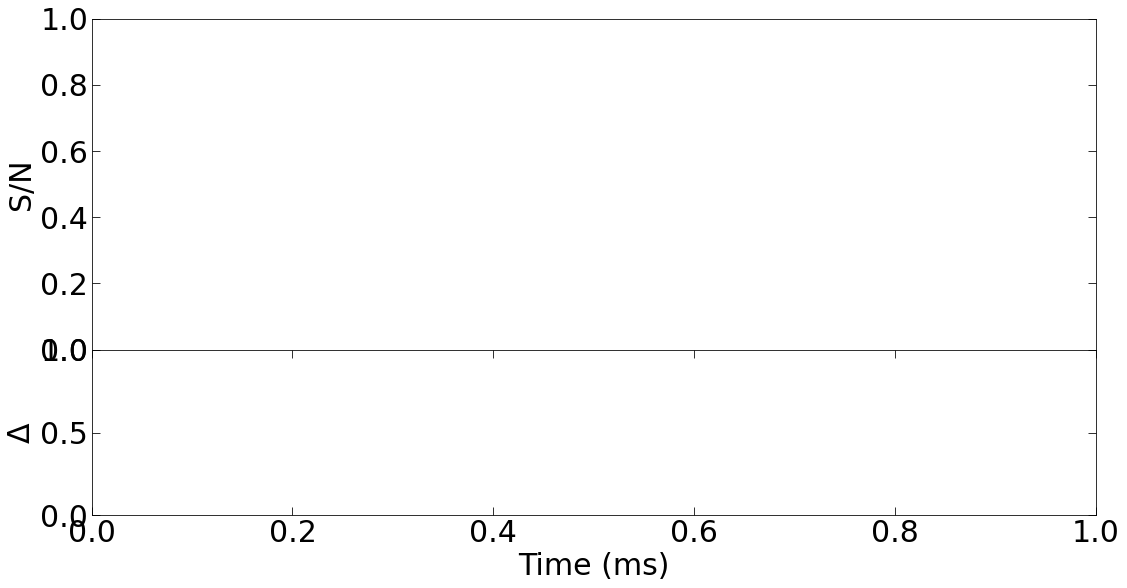

In [6]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    #Slide Title
    mr.Markdown("### (0) Load Data")
    
    #main screen
    nbox = None
    try:

        nbox = parsec.load_screen(frbfiles_menu,base_n_t_slider,base_logn_f_slider,logibox_slider_init,
               buff_L_slider_init,buff_R_slider_init,RA_display,DEC_display,DM_init_display,ibeam_display,
               mjd_display,z_display,updatebutton,filbutton,
               loadbutton,polcalloadbutton)
    except KeyError as ex:
        print("Preceding Stages Required")

    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    # slide title
    mr.Markdown("### (1) Dedispersion Tuning")
    
    mr.Markdown("##### DM Parameters")


    #if not (parsec.state_dict["current_state"] >= parsec.state_map['dedisp']): raise parsec.StopExecution
    DM_input_display = mr.NumberBox(data=parsec.wdict['DM_input_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                    title=r'Input DM (pc/cm$^{{3}}$)'
                                   )
    DM_new_display = mr.NumberBox(data=DM_input_display.data + ddm_num.value, 
                                  title=r'New DM (pc/cm$^{{3}}$)'
                                 )

    nbox=mr.NumberBox([DM_input_display,DM_new_display])


    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    
    mr.Markdown("### (2) Calibration")
    
    mr.Markdown(" Observation Beams:")
    #if parsec.state_dict["current_state"] >= parsec.state_map['polcal']:
    try:
        beam_dict_3C48,beam_dict_3C286 = parsec.polcal_screen(polcaldate_menu,polcaldate_create_menu,polcaldate_bf_menu,polcaldate_findbeams_menu,obsid3C48_menu,obsid3C286_menu,
                                                         polcalbutton,polcopybutton,bfcal_button,findbeams_button,filcalbutton,ParA_display,
                                                         edgefreq_slider,breakfreq_slider,sf_window_weight_cals,sf_order_cals,peakheight_slider,peakwidth_slider,polyfitorder_slider,
                                                         ratio_edgefreq_slider,ratio_breakfreq_slider,ratio_sf_window_weight_cals,ratio_sf_order_cals,ratio_peakheight_slider,ratio_peakwidth_slider,ratio_polyfitorder_slider,
                                                         phase_sf_window_weight_cals,phase_sf_order_cals,phase_peakheight_slider,phase_peakwidth_slider,phase_polyfitorder_slider,savecalsolnbutton,
                                                         sfflag,polyfitflag,ratio_sfflag,ratio_polyfitflag,phase_sfflag,phase_polyfitflag,saveplotbutton)
    except KeyError as ex:
        print("Preceding Stages Required")
        
        
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    mr.Markdown("### (3) Filter Weights")
    try:
        parsec.filter_screen(logwindow_slider,logibox_slider,
                         buff_L_slider,buff_R_slider,ncomps_num,comprange_slider,nextcompbutton,donecompbutton,
                        avger_w_slider,sf_window_weights_slider,multipeaks,multipeaks_height_slider,fluxestbutton,
                            Iflux_display,Qflux_display,Uflux_display,Vflux_display)
    except KeyError as ex:
        print("Preceding Stages Required")
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    mr.Markdown("### (4) Scattering Analysis")
    #try:
    scatterresult = parsec.scatter_screen(scattermenu,scatfitmenu,x0_guess_comps,sigma_guess_comps,tau_guess_comps,amp_guess_comps,x0_range_sliders,sigma_range_sliders,tau_range_sliders,amp_range_sliders,calc_scat_button,save_scat_button,scatterbackground,refresh_button,scatterresume,scatterweights,scatter_nlive,scatter_init,scatter_sliderrange)
    #except KeyError as ex:
    #    print("Preceding Stages Required")

    
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    mr.Markdown("### (5) Scintillation Analysis")
    try:
        parsec.scint_screen(scintfitmenu,calc_bw_button,gamma_guess,m_guess,c_guess,scintmenu,scint_fit_range,save_scint_button)
    except KeyError as ex:
        print("Preceding Stages Required")
        
#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    mr.Markdown("### (6) RM Synthesis")
    try:
        parsec.RM_screen(useRMTools,maxRM_num_tools,dRM_tools,useRMsynth,nRM_num,minRM_num,
                     maxRM_num,getRMbutton,useRM2D,nRM_num_zoom,RM_window_zoom,dRM_tools_zoom,getRMbutton_zoom,
                    RM_gal_display,RM_galerr_display,RM_ion_display,RM_ionerr_display,getRMgal_button,getRMion_button,
                    rmcomp_menu,RMsynthbackground,refresh_button)
    except KeyError as ex:
        print("Preceding Stages Required")
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    mr.Markdown("### (7) Polarization Analysis")
    try:
        fig,fig_time,fig_freq = parsec.polanalysis_screen(showghostPA,intLbuffer_slider,intRbuffer_slider,polcomp_menu)
    except KeyError as ex:
        fig = fig_time = fig_freq = None
        print("Preceding Stages Required")
    mr.Markdown("#### Pol and S/N Table")
    nbox=mr.Table(data=parsec.poldf, width="200px")

    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    mr.Markdown("### (8) Archive Data")
    try:
        parsec.archive_screen(savebutton,archivebutton,archivepolcalbutton,spreadsheetbutton,notesinput)
    except KeyError as ex:
        print("Preceding Stages Required")
    mr.Markdown("#### RM Table (See Van Eck et al. 2023)")
    nbox = mr.Table(data=parsec.RMtable_archive_df.to_pandas(), width="200px")#, text_align="center")
    
nbox

In [7]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    #display filterbank files if they exist
    if 'fils' in parsec.state_dict.keys():
        if len(parsec.state_dict['fils']) == 0:
            mr.Markdown(text=r'##### **Filterbanks:** None Found')
        else:
            mr.Markdown(text=r'##### **Filterbanks:** ')
            for f in parsec.state_dict['fils']:
                mr.Markdown(r'###### -' + str(f))

    #display beamformer weights date if exists
    if 'bfweights' in parsec.state_dict.keys():
        if parsec.state_dict['bfweights'] is None:
            bfweights_text = r'##### **Beamformer Weights:** None Found'
        else:
            bfweights_text = r'##### **Beamformer Weights:** ' + parsec.state_dict['bfweights']
        bfweights_display = mr.Markdown(text=bfweights_text)

    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    try:
        parsec.dedisp_screen(n_t_slider,logn_f_slider,logwindow_slider_init,ddm_num,
                             DM_input_display,DM_new_display,DMdonebutton,saveplotbutton)
    except KeyError as ex:
        print("Preceding Stages Required")


    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    
    mr.Markdown(" Polarization Calibration Solution:")
    try:
        nbox = parsec.polcal_screen2(polcaldate_menu,polcaldate_create_menu,polcaldate_bf_menu,polcaldate_findbeams_menu,obsid3C48_menu,obsid3C286_menu,
                                                         polcalbutton,polcopybutton,bfcal_button,findbeams_button,filcalbutton,ParA_display,
                                                         edgefreq_slider,breakfreq_slider,sf_window_weight_cals,sf_order_cals,peakheight_slider,peakwidth_slider,polyfitorder_slider,
                                                         ratio_edgefreq_slider,ratio_breakfreq_slider,ratio_sf_window_weight_cals,ratio_sf_order_cals,ratio_peakheight_slider,ratio_peakwidth_slider,ratio_polyfitorder_slider,
                                                         phase_sf_window_weight_cals,phase_sf_order_cals,phase_peakheight_slider,phase_peakwidth_slider,phase_polyfitorder_slider,savecalsolnbutton,
                                                         sfflag,polyfitflag,ratio_sfflag,ratio_polyfitflag,phase_sfflag,phase_polyfitflag,beam_dict_3C48,beam_dict_3C286,saveplotbutton)
    except KeyError as ex:
        print("Preceding Stages Required")
        
        
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    nbox = mr.Table(data=parsec.df, width="200px")#, text_align="center")
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    mr.Markdown("Scattering Analysis Corner Plot:")
    if scatterresult is not None:
        figscatter = plt.figure(figsize=(18,12))
        nbox = scatterresult.plot_corner(fig=figscatter)
        if scatterbackground.value:
            os.system("cp " + parsec.dirs['logs'] + "scat_files/" + parsec.state_dict['scatter_dname'] + "* " + parsec.state_dict['datadir'])

#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    mr.Markdown("Scintillation Analysis Results:")
    nbox = mr.Table(data=parsec.df_scint, width="400px")

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    rmcal_menu = mr.Select(label="Calibration RM:", 
                                value=parsec.wdict['rmcal_menu'],
                                choices=parsec.wdict['rmcal_menu_choices'],
                                hidden=hidden)#frbfiles[0], choices=frbfiles,hidden=hidden)

    rmcal_input = mr.Numeric(value=parsec.wdict['rmcal_input'], 
                         step=0.01,
                         min=-1e6,max=1e6,
                         label='Input RM (rad/m$^{{2}}$)',
                         hidden=(hidden | ('Input RM' not in rmcal_menu.value)))


    RMcalibratebutton = mr.Button(label='Apply RM Calibration',
                                 style='primary',hidden=hidden)
    
    
    try:
        parsec.RM_screen_plot(rmcal_menu,RMcalibratebutton,RMdisplay,RMerrdisplay,rmcal_input)
    except KeyError as ex:
        print("Preceding Stages Required")
        
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    mr.Markdown("#### Summary Plot")
    nbox = fig
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(rmtablefuncs.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))

    
nbox

Scattering Analysis Corner Plot:

In [8]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    mr.Markdown("##### FRB Parameters")
    nbox=mr.NumberBox([RA_display,DEC_display,z_display,ibeam_display])
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(dedisp.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))


    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    
    mr.Markdown(" Parallactic Angle Estimate:")
    #if not (parsec.state_dict["current_state"] >= parsec.state_map['polcal']): raise parsec.StopExecution
    nbox = ParA_display
        
        
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    nbox=mr.NumberBox([Iflux_display,Qflux_display,Uflux_display,Vflux_display])
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    mr.Markdown("Scattering Analysis Results:")
    nbox = mr.Table(data=parsec.df_scat, width="400px")


    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(scatscint.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))


#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    mr.Markdown("#### RM Applied")
    nbox=mr.NumberBox([RMdisplay,RMerrdisplay])
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    mr.Markdown("#### Time Domain")
    nbox=fig_time
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

Scattering Analysis Results:

In [9]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    nbox=mr.NumberBox([mjd_display,DM_init_display])

#(6) RM ANALYSIS
#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    
    mr.Markdown("#### RM Table")
    nbox =mr.Table(data=parsec.RMdf, width="200px")#, text_align="center")
nbox

In [10]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    mr.Markdown("##### Log:")
    #if showlog.value:# or refreshlogbutton.clicked:
    flog = open(polbeamform.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    
    mr.Markdown(" Table of Pol Cal Voltages on T3:")
    nbox = mr.Table(data=parsec.df_polcal, width="200px")
        
        
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(filt.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(scatscint.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    nbox=mr.NumberBox([RM_gal_display,RM_galerr_display,RM_ion_display,RM_ionerr_display])
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    mr.Markdown("#### Spectrum")
    nbox = fig_freq
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

 Log:

In [11]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    pass
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    
    mr.Markdown(" Selected 3C48 Pol Cal Files:")
    #display voltages and beamformer weight files for current selection
    if polcaldate_bf_menu.value != "":
        #display filterbank files if they exist
        if 'polcal_avail_3C48' in parsec.polcal_dict.keys():
            if len(parsec.polcal_dict['polcal_avail_3C48']) == 0:
                mr.Markdown(text=r'###### **3C48 Voltages:** None Found')
            else:
                mr.Markdown(text=r'###### **3C48 Voltages:** ')
                for f in parsec.state_dict['polcal_avail_3C48']:
                    mr.Markdown(r'- ######' + f)
        if 'polcal_avail_bf_3C48' in parsec.polcal_dict.keys():
            if len(parsec.polcal_dict['polcal_avail_bf_3C48']) == 0:
                mr.Markdown(text=r'##### **3C48 Beamformer Weights:** None Found')
            else:
                mr.Markdown(text=r'##### **3C48 Beamformer Weights:** ')
                for f in parsec.state_dict['polcal_avail_bf_3C48']:
                    mr.Markdown(r'- #####' + f)
        
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    pass
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    pass
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    trialz = mr.Numeric(value=parsec.wdict['trialz'], 
                     step=1e-3,
                     min=-1,max=10,
                     label='Trial Redshift z'
                    ,hidden=hidden)
    
    mr.Markdown("#### DM Budget")
    parsec.DM_Budget_screen(trialz)
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(dsapol.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

In [12]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    pass
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    mr.Markdown(" Selected 3C286 Pol Cal Files:")
    #display voltages and beamformer weight files for current selection
    if polcaldate_bf_menu.value != "":
        #display filterbank files if they exist
        if 'polcal_avail_3C286' in parsec.polcal_dict.keys():
            if len(parsec.polcal_dict['polcal_avail_3C286']) == 0:
                mr.Markdown(text=r'###### **3C286 Voltages:** None Found')
            else:
                mr.Markdown(text=r'###### **3C286 Voltages:** ')
                for f in parsec.polcal_dict['polcal_avail_3C286']:
                    mr.Markdown(r'- ######' + f)
        if 'polcal_avail_bf_3C286' in parsec.polcal_dict.keys():
            if len(parsec.polcal_dict['polcal_avail_bf_3C286']) == 0:
                mr.Markdown(text=r'##### **3C286 Beamformer Weights:** None Found')
            else:
                mr.Markdown(text=r'##### **3C286 Beamformer Weights:** ')
                for f in parsec.polcal_dict['polcal_avail_bf_3C286']:
                    mr.Markdown(r'- #####' + f)
                    
        
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    pass
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    pass
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    mr.Markdown("#### RM Budget")
    parsec.RM_Budget_screen(trialz)
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    pass
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

In [13]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    pass
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    
    #display beam numbers for each cal pass
    mr.Markdown(" Table of Local Pol Cal Filterbanks:")
    nbox = mr.Table(data=parsec.df_beams,width="200px") 
    
    
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    pass
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    pass
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    mr.Markdown("#### Host B Field Estimate")
    parsec.Bfield_Budget_screen()
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    pass
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

In [14]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    pass
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    #3C48 
    mr.Markdown(" Selected 3C48 Filterbanks and Weights:")
    if obsid3C48_menu.value != '':
        obs_files,obs_ids = polcal.get_calfil_files('3C48',polcaldate_findbeams_menu.value,obsid3C48_menu.value)
        if len(obs_files) == 0: mr.Markdown(text = r'##### **' + obsid3C48_menu.value + ' Filterbanks:** None Found')
        else:
            mr.Markdown(text=r'##### **' + obsid3C48_menu.value + ' Filterbanks:**')
            for f in obs_files:
                mr.Markdown(r'- #####' + f)

        if obsid3C48_menu.value in parsec.df_beams.index.tolist():#beam_dict_3C48.keys():
            #print(beam_dict_3C48.keys())
            mr.Markdown(text=r'##### **' + obsid3C48_menu.value + ' Beamformer Weights:**')
            #print(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C48'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C48_menu.value][:19] + "*")
            bf_files = glob.glob(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C48'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C48_menu.value][:19] + "*")
            for f in bf_files:
                mr.Markdown(text = r'- #####' + f)
        else:
            mr.Markdown(text = r'##### **' + obsid3C48_menu.value + ' Beamformer Weights:** None Found')

    

#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    pass
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    pass
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(RMcal.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    pass
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

In [15]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    pass
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    #3C286
    mr.Markdown(" Selected 3C286 Filterbanks and Weights:")
    if obsid3C286_menu.value != '':
        obs_files,obs_ids = polcal.get_calfil_files('3C286',polcaldate_findbeams_menu.value,obsid3C286_menu.value)
        if len(obs_files) == 0: mr.Markdown(text = r'##### **' + obsid3C286_menu.value + ' Filterbanks:** None Found')
        else:
            mr.Markdown(text=r'##### **' + obsid3C286_menu.value + ' Filterbanks:**')
            for f in obs_files:
                mr.Markdown(text = r'- #####' + f)

        if obsid3C286_menu.value in parsec.df_beams.index.tolist():
            mr.Markdown(text=r'##### **' + obsid3C286_menu.value + ' Beamformer Weights:**')
            bf_files = glob.glob(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C286'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C286_menu.value][:19] + "*")
            #print(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C286'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C286_menu.value][:19] +  "*")
            for f in bf_files:
                mr.Markdown(text = r'- #####' + f)
        else:
            mr.Markdown(text=r'##### **' + obsid3C286_menu.value + ' Beamformer Weights:** None Found')

    
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    pass
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    pass
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    pass
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    pass
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox

In [16]:
nbox = None
#(0) LOAD DATA
hidden = toggle_menu.value != '(0) Load Data'
if not hidden:
    pass
    
#(1) DEDISPERSION

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
if not hidden:
    pass

    
#(2) CALIBRATION


hidden = '(2)' not in toggle_menu.value 
if not hidden:
    # display the output of the logfile
    mr.Markdown(" Log:")
    #if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(polcal.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))
    
#(3) FILTERING
hidden = toggle_menu.value != '(3) Filter Weights'
if not hidden:
    pass
    
#(4) SCATTERING
#widgets for scattering dashboard
hidden = toggle_menu.value != '(4) Scattering Analysis'
if not hidden:
    pass
    
#(5) SCINTILLATION
hidden = toggle_menu.value != '(5) Scintillation Analysis'
if not hidden:
    pass

#(6) RM ANALYSIS

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(6) RM Synthesis'
if not hidden:
    pass
    
#(7) POLARIZATION ANALYSIS
hidden = toggle_menu.value != '(7) Polarization Analysis'
if not hidden:
    pass
    
#(8) ARCHIVE
#widgets for pol analysis dashboard
hidden = toggle_menu.value != '(8) Archive Data'
if not hidden:
    pass
    
nbox


    